In [ ]:
!pip install pymongo --quiet
!pip install python-dotenv --quiet

from pymongo import MongoClient
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 14.8 MB/s eta 0:00:00


## **Connection to MongoDB and get Documents**

In [ ]:
# Configuration
MONGO_URI = ""
DATABASE_NAME = ""
COLLECTION_NAME = ""

def connect_to_mongodb(mongo_uri):
    """Function to connect to mongodb client.
    Return mongodb client if successfull."""

    # Connect to server
    mongo_client = MongoClient(mongo_uri)

    # Ping to server
    try:
      mongo_client.admin.command('ping')
      print("Pinged your deployment. You successfully connected to MongoDB!")
    except Exception as e:
      raise Exception(f"Connection failed: {e}")

    return mongo_client

def get_database(mongo_client, database_name):
    """Function to get database from mongodb client."
    Return database if successfull."""

    # Get database
    try:
      database = mongo_client[database_name]
      print(f"Database '{database_name}' connected successfully!")
    except Exception as e:
      raise Exception(f"Connection failed: {e}")

    return database

def get_collection(database, collection_name):
    """Function to get collection from database."
    Return collection if successfull."""

    # Get collection
    try:
      collection = database[collection_name]
      print(f"Collection '{collection_name}' connected successfully!")
    except Exception as e:
      raise Exception(f"Connection failed: {e}")

    return collection

def get_all_documents(collection):
    """Function to get all documents from collection.
        Return list of documents.
    """
    all_documents = []
    try:
        documents = collection.find()
        for document in documents:
          all_documents.append(document)
    except Exception as e:
      raise Exception(f"Connection failed: {e}")

    return all_documents

In [ ]:
# Connect to MongoDB and get collection
mongo_client = connect_to_mongodb(MONGO_URI)
database = get_database(mongo_client, DATABASE_NAME)
collection = get_collection(database, COLLECTION_NAME)

Pinged your deployment. You successfully connected to MongoDB!
Database 'Film' connected successfully!
Collection 'word_embedding_preprocessed' connected successfully!


In [ ]:
# Get all documents
all_documents = get_all_documents(collection)

# Print some samples
all_documents[:1]

[{'_id': ObjectId('6839ee0bdba46ba351845660'),
  'id': 'tt0006621',
  'cleaned_description': ['when',
   'isabel',
   'carlisle',
   'mistakenly',
   'belief',
   'that',
   'her',
   'husband',
   'richard',
   'love',
   'barbara',
   'hare',
   'she',
   'leaf',
   'him',
   'their',
   'two',
   'child',
   'she',
   'doe',
   'nothing',
   'to',
   'correct',
   'report',
   'that',
   'she',
   'ha',
   'been',
   'killed',
   'in',
   'train',
   'wreck',
   'so',
   'richard',
   'believing',
   'himself',
   'to',
   'be',
   'widower',
   'marries',
   'barbara',
   'after',
   'few',
   'month',
   'isabel',
   'longs',
   'to',
   'see',
   'her',
   'child',
   'so',
   'disguising',
   'herself',
   'get',
   'job',
   'a',
   'their',
   'governess',
   'then',
   'when',
   'her',
   'son',
   'becomes',
   'ill',
   'call',
   'out',
   'for',
   'his',
   'mother',
   'isabel',
   'throw',
   'off',
   'her',
   'disguise',
   'go',
   'to',
   'comfort',
   'him',
  

In [ ]:
df = pd.DataFrame(all_documents)

# Mở rộng metadata
meta_df = pd.json_normalize(df["metadata"])
df = df.join(meta_df).drop(columns=["metadata"])
df = df.drop(columns=['_id', 'id'])

In [ ]:
print("Total Movies:", len(df))
print(df.info())

print("\nMissing information:")
print(df.isnull().sum())

Total Movies: 9504
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cleaned_description   9504 non-null   object 
 1   original_description  9504 non-null   object 
 2   film_name             9504 non-null   object 
 3   image_link            9504 non-null   object 
 4   is_adult              9504 non-null   int64  
 5   start_year            9504 non-null   int64  
 6   runtime_minutes       7668 non-null   float64
 7   genres                9365 non-null   object 
 8   rating                6017 non-null   float64
 9   votes                 6017 non-null   float64
 10  directors             9402 non-null   object 
 11  writers               8972 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 891.1+ KB
None

Missing information:
cleaned_description        0
original_description       0
film_name  

## **Movie Information Analysis**

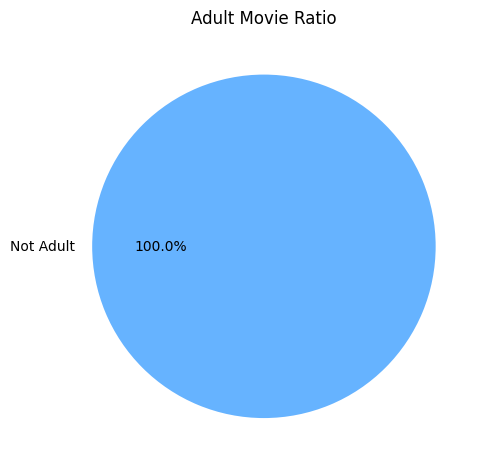

In [ ]:
#Tỷ lệ phim người lớn / không người lớn
plt.figure(figsize=(5,5))
df["is_adult"].value_counts().plot.pie(autopct="%.1f%%", labels=["Not Adult", "Adult"], colors=["#66b3ff", "#ff9999"])
plt.title("Adult Movie Ratio")
plt.ylabel("")
plt.tight_layout()
plt.show()

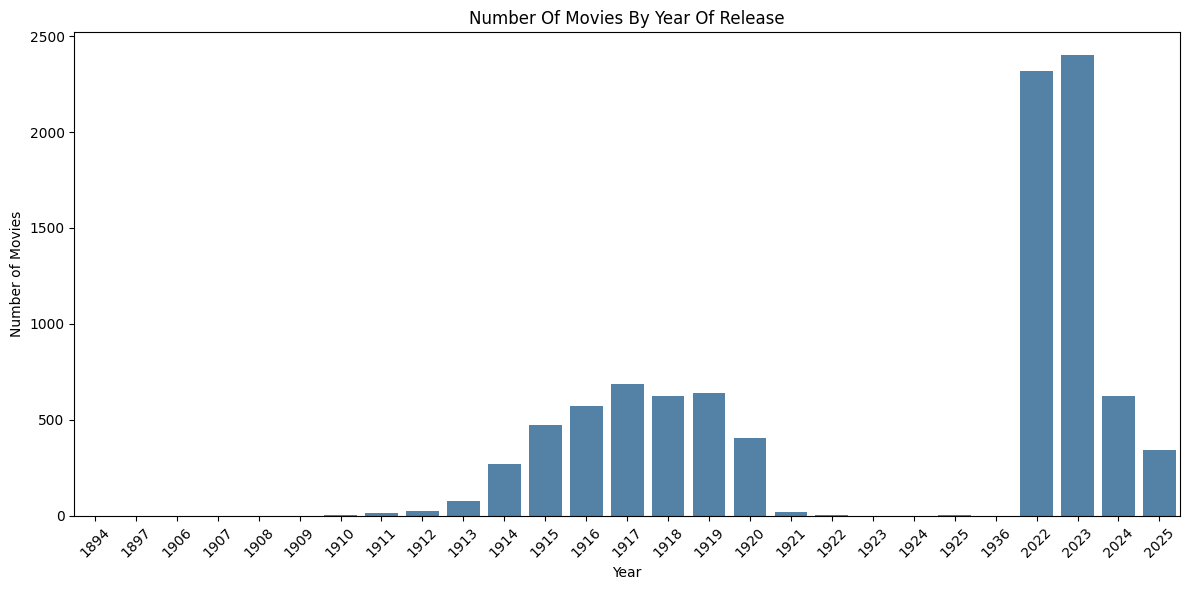

In [ ]:
#Năm phát hành
plt.figure(figsize=(12, 6))

df["start_year"] = pd.to_numeric(df["start_year"], errors="coerce")
df_filtered = df.dropna(subset=["start_year"])
df_filtered["start_year"] = df_filtered["start_year"].astype(int)

sns.countplot(data=df_filtered, x="start_year", color='steelblue')
plt.xticks(rotation=45)
plt.title("Number Of Movies By Year Of Release")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


In [ ]:
#Phân tích thời lượng phim
runtime = df["runtime_minutes"].dropna()

# Tính IQR để loại các giá trị outlier
Q1 = runtime.quantile(0.25)
Q3 = runtime.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_runtime = runtime[(runtime >= lower_bound) & (runtime <= upper_bound)]
df_runtime.describe()

,runtime_minutes
count,7599.000000
mean,82.543098
std,28.523298
min,3.000000
25%,50.000000
50%,84.000000
75%,101.000000
max,177.000000


In [ ]:
#Rating
rating_series = df["rating"].dropna()
rating_series.describe()

,rating
count,6017.000000
mean,6.090128
std,1.440450
min,1.000000
25%,5.200000
50%,6.100000
75%,7.000000
max,10.000000


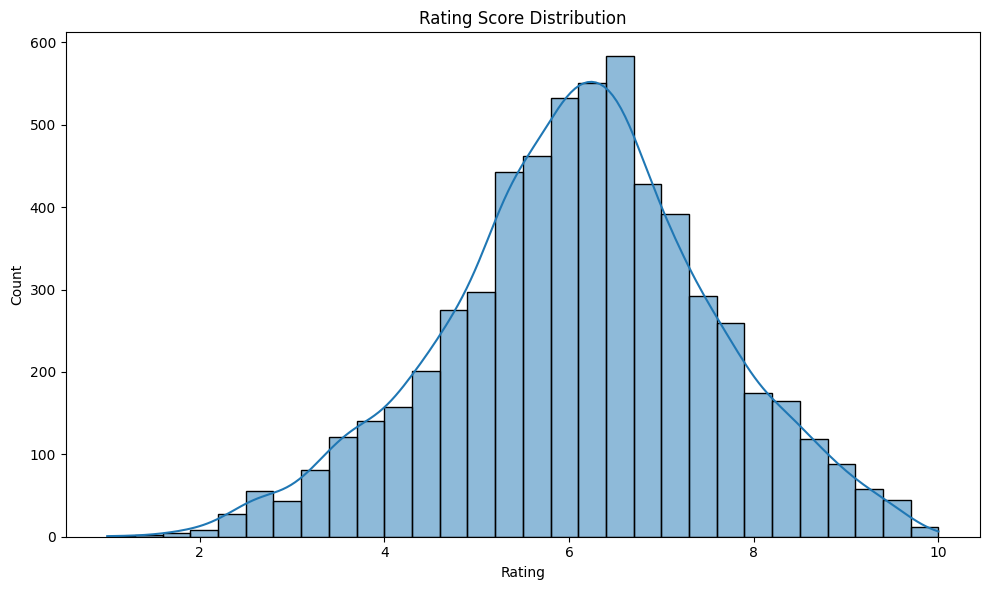

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rating_series, bins=30, kde=True)
plt.title("Rating Score Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Lấy top 10 phim rating cao nhất và thấp nhất
rating_high = df.nlargest(10, "rating")[["film_name", "directors", "start_year", "runtime_minutes", "votes", "rating"]].reset_index(drop=True)
rating_low = df.nsmallest(10, "rating")[["film_name", "directors", "start_year", "runtime_minutes", "votes", "rating"]].reset_index(drop=True)

print("Top 10 Highest Rated Movies:")
display(rating_high)

print("\nTop 10 Lowest Rated Movies:")
display(rating_low)

Top 10 Highest Rated Movies:


,film_name,directors,start_year,runtime_minutes,votes,rating
0,Karma Bums,Keon Hedayati,2022,NaN,7.0,10.0
1,The Place in Between,Laura Perez,2024,NaN,9.0,9.8
2,What's in A Name - A Versace Story,Terence Gordon,2022,NaN,9.0,9.8
3,Institute of Pavtollogy,"Prasad Namjoshi, Sagar Vanjari",2025,139.0,7.0,9.8
4,Weirdo: The Story of Five Eight,Marc Pilvinsky,2024,103.0,9.0,9.7
5,Baldy for the Blind,Drea Castro,2024,78.0,54.0,9.7
6,Bilbo and the Legend of the Last Living Cow,Thang Ho,2022,88.0,9.0,9.7
7,Molulo 2: Jodohku yang Mana?,"Irham Acho Bahtiar, Hendrick Jhansen Metemko",2022,116.0,78.0,9.7
8,Tears of Blood,Joshua Clay,2024,NaN,8.0,9.7
9,Losers of Eden,Kevin Briot,2023,91.0,9.0,9.7



Top 10 Lowest Rated Movies:


,film_name,directors,start_year,runtime_minutes,votes,rating
0,Miss Nobody,Francis J. Grandon,1920,NaN,24.0,1.0
1,Love Song and Power,"Erik Krefeld, Eddel Martinez",2024,90.0,8.0,1.4
2,Amityville: Where the Echo Lives,Carlos Ayala,2024,89.0,408.0,1.5
3,The Paradise Motel,Walter Hochbrueckner,2022,80.0,149.0,1.7
4,Graustark,Fred E. Wright,1915,NaN,24.0,1.8
5,One Hour,"Edwin L. Hollywood, Paul McAllister",1917,60.0,26.0,1.8
6,Honey Trap,"Tom Hillery, Jack E. Bell",2022,90.0,43.0,1.8
7,The Three Musketeers,Bill Thomas,2023,99.0,1027.0,1.8
8,A Man's Fight,Thomas N. Heffron,1919,50.0,28.0,1.9
9,The Ladykiller,Ajay Bahl,2023,125.0,1096.0,1.9


In [ ]:
# Lấy top 10 phim có votes cao nhất và thấp nhất
votes_high = df.nlargest(10, "votes")[["film_name", "directors", "start_year", "runtime_minutes", "rating", "votes"]].reset_index(drop=True)
votes_low = df.nsmallest(10, "votes")[["film_name", "directors", "start_year", "runtime_minutes", "rating", "votes"]].reset_index(drop=True)

print("Top 10 Highest Votes Movies:")
display(votes_high)

print("\nTop 10 Lowest Votes Movies:")
display(votes_low)

Top 10 Highest Votes Movies:


,film_name,directors,start_year,runtime_minutes,rating,votes
0,Oppenheimer,Christopher Nolan,2023,180.0,8.3,894728.0
1,Barbie,Greta Gerwig,2023,114.0,6.8,609292.0
2,The Kashmir Files,Vivek Agnihotri,2022,170.0,8.5,576345.0
3,Bullet Train,David Leitch,2022,127.0,7.3,493732.0
4,Glass Onion,Rian Johnson,2022,139.0,7.1,477292.0
5,Thor: Love and Thunder,Taika Waititi,2022,118.0,6.2,434464.0
6,John Wick: Chapter 4,Chad Stahelski,2023,169.0,7.6,378599.0
7,Poor Things,Yorgos Lanthimos,2023,141.0,7.8,342796.0
8,Nope,Jordan Peele,2022,130.0,6.8,299655.0
9,Furiosa: A Mad Max Saga,George Miller,2024,148.0,7.5,288503.0



Top 10 Lowest Votes Movies:


,film_name,directors,start_year,runtime_minutes,rating,votes
0,Cross Dreamers,Soledad Velasco,2022,78.0,8.2,5.0
1,Manuela,Clara Cullen,2022,90.0,7.4,5.0
2,Rebirth: Voice of Silence,Ilija Pavlov,2022,85.0,8.4,5.0
3,El Plan,Robert Cornelio,2023,NaN,5.8,5.0
4,Qajymuqan,Kanagat Mustafin,2024,NaN,4.8,5.0
5,A Sunken Place,Ronan O'Leary,2023,111.0,7.8,5.0
6,Balika,"Lander Ibarretxe, Aitor Sanchez",2022,65.0,7.2,5.0
7,Meeting Kate,Jefferson Moore,2023,NaN,6.2,5.0
8,Apocalypse Love,Vera VanGuard,2024,NaN,6.4,5.0
9,Journal intime,Mohamed Chrif Tribak,2024,115.0,8.6,5.0


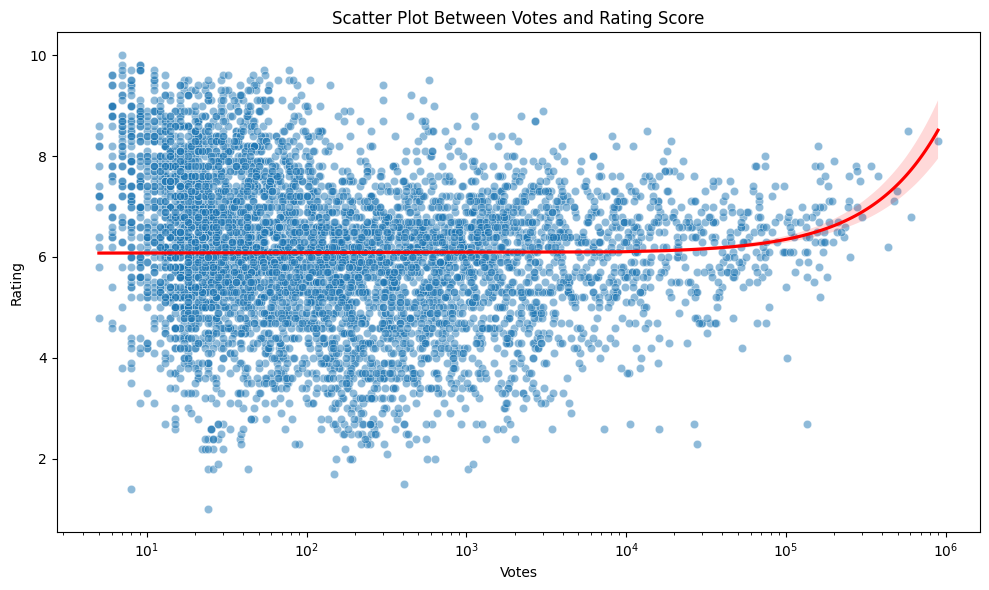

In [ ]:
#Scatterplot votes và rating
df_votes_rating = df[["votes", "rating"]].dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_votes_rating, x="votes", y="rating", alpha=0.5)
sns.regplot(data=df_votes_rating, x="votes", y="rating", scatter=False, color='red')
plt.title("Scatter Plot Between Votes and Rating Score")
plt.xlabel("Votes")
plt.ylabel("Rating")
plt.xscale('log')
plt.tight_layout()
plt.show()


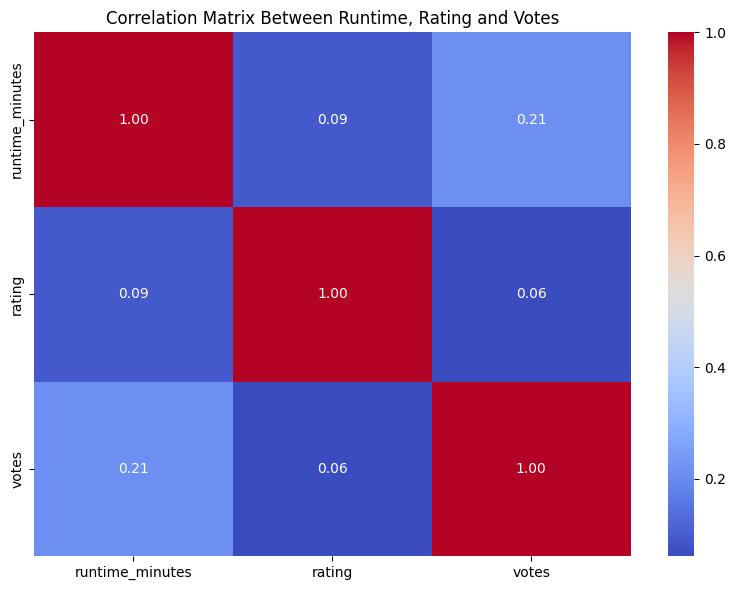

In [ ]:
#Heatmap
df_corr = df[df["runtime_minutes"].between(lower_bound, upper_bound)][["runtime_minutes", "rating", "votes"]].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Between Runtime, Rating and Votes")
plt.tight_layout()
plt.show()

Number of Movie Genres: 24 genres

List of Movie Genres:
Action, Adventure, Animation, Biography, Comedy, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Music, Musical, Mystery, News, Reality-TV, Romance, Sci-Fi, Sport, Talk-Show, Thriller, War, Western


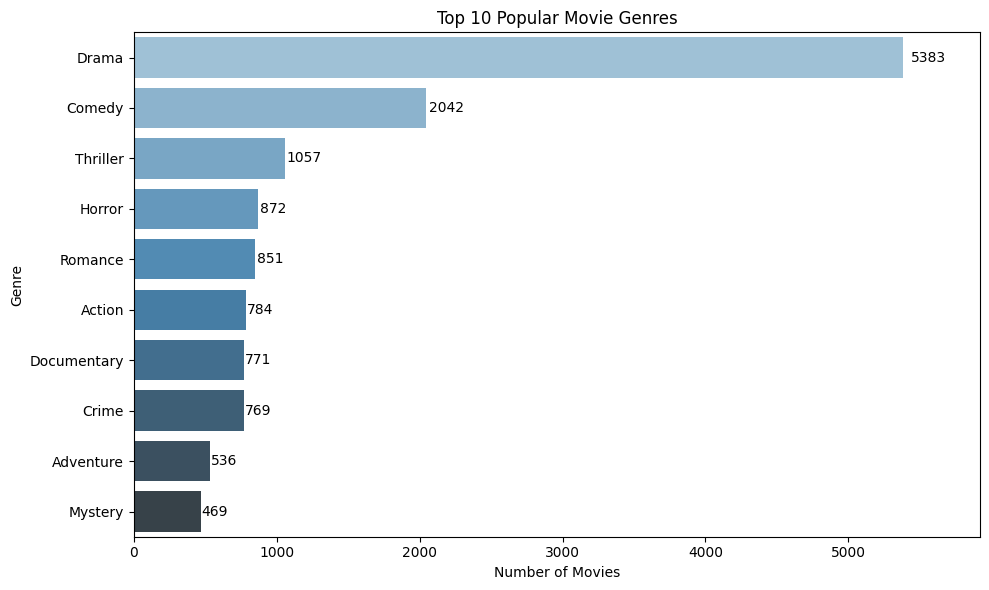

In [ ]:
#In thể loại và top 10 phổ biến
genre_series = df["genres"].dropna().str.split(",").explode()
unique_genres = sorted(genre_series.str.strip().unique())
print(f"Number of Movie Genres: {len(unique_genres)} genres")
print("\nList of Movie Genres:")
print(", ".join(unique_genres))

top_genres = genre_series.value_counts().head(10)
top_genres_df = top_genres.reset_index()
top_genres_df.columns = ["genre", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="genre", hue="genre", data=top_genres_df, palette="Blues_d", legend=False)

for i, v in enumerate(top_genres_df["count"]):
    ax.text(v * 1.01, i, str(v), va="center")

plt.xlim(0, top_genres_df["count"].max() * 1.1)
plt.title("Top 10 Popular Movie Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


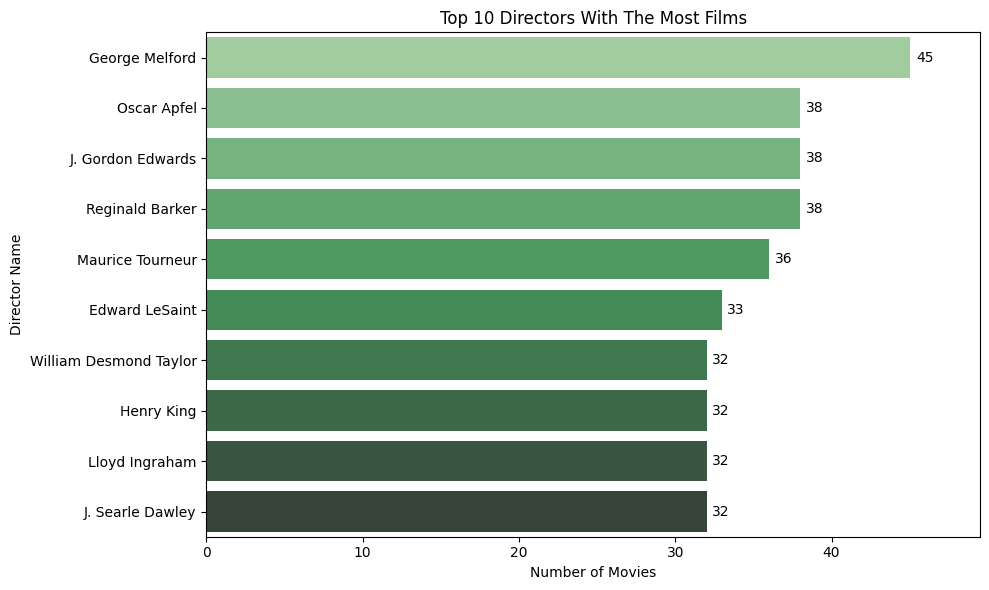

In [ ]:
#Top 10 đạo diễn
directors = df["directors"].dropna().str.split(",").explode()
top_directors = directors.value_counts().head(10)
top_directors_df = top_directors.reset_index()
top_directors_df.columns = ["director", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="director", hue="director", data=top_directors_df, palette="Greens_d", legend=False)

for i, v in enumerate(top_directors_df["count"]):
    ax.text(v * 1.01, i, str(v), va="center")

plt.xlim(0, top_directors_df["count"].max() * 1.1)
plt.title("Top 10 Directors With The Most Films")
plt.xlabel("Number of Movies")
plt.ylabel("Director Name")
plt.tight_layout()
plt.show()

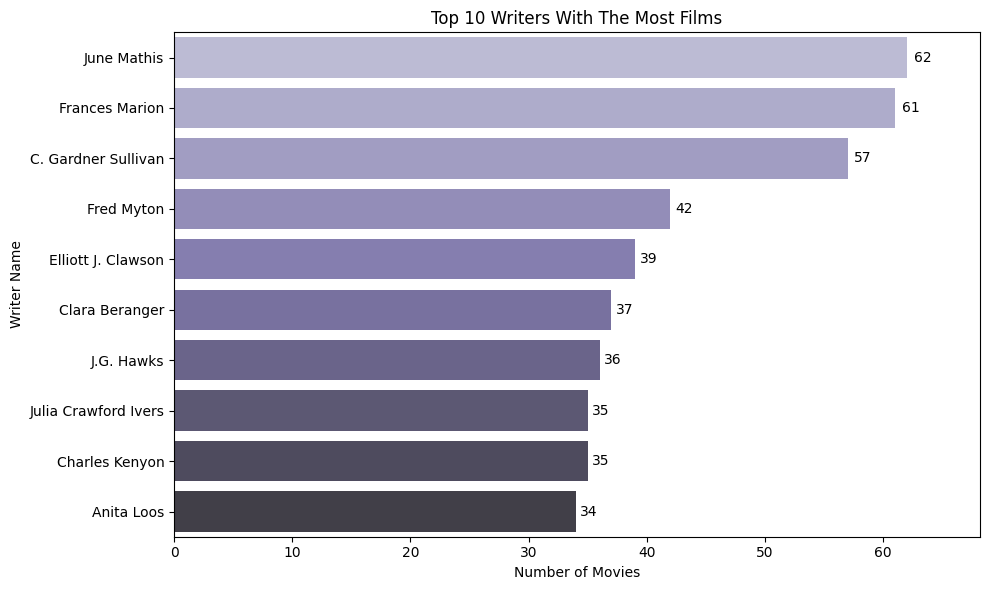

In [ ]:
#Top 10 biên kịch
writer_series = df["writers"].dropna().str.split(",").explode().str.strip()
top_writers = writer_series.value_counts().head(10)
top_writers_df = top_writers.reset_index()
top_writers_df.columns = ["writer", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="writer", hue="writer", data=top_writers_df, palette="Purples_d", legend=False)

for i, v in enumerate(top_writers_df["count"]):
    ax.text(v * 1.01, i, str(v), va="center")

plt.xlim(0, top_writers_df["count"].max() * 1.1)
plt.title("Top 10 Writers With The Most Films")
plt.xlabel("Number of Movies")
plt.ylabel("Writer Name")
plt.tight_layout()
plt.show()

## **Word Frequency Analysis**

Movie description length statistics:
count    9504.000000
mean      657.577020
std       789.409125
min         4.000000
25%       198.000000
50%       384.500000
75%       847.000000
max      8227.000000
Name: description_length, dtype: float64


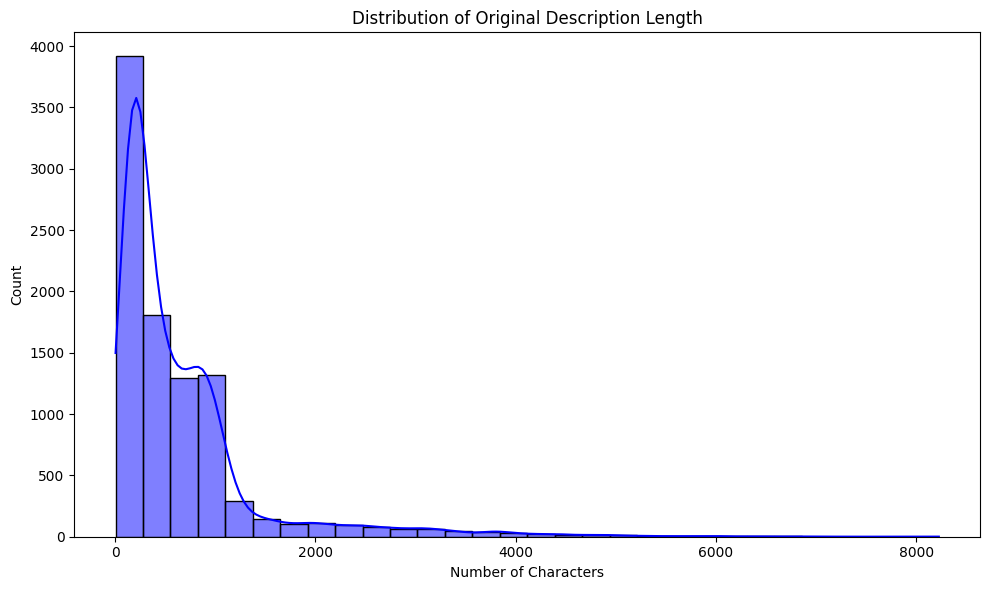

In [ ]:
#Phân tích độ dài mô tả
df["description_length"] = df["original_description"].astype(str).apply(len)

print("Movie description length statistics:")
print(df["description_length"].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df["description_length"], bins=30, kde=True, color="blue")
plt.title("Distribution of Original Description Length")
plt.xlabel("Number of Characters")
plt.tight_layout()
plt.show()

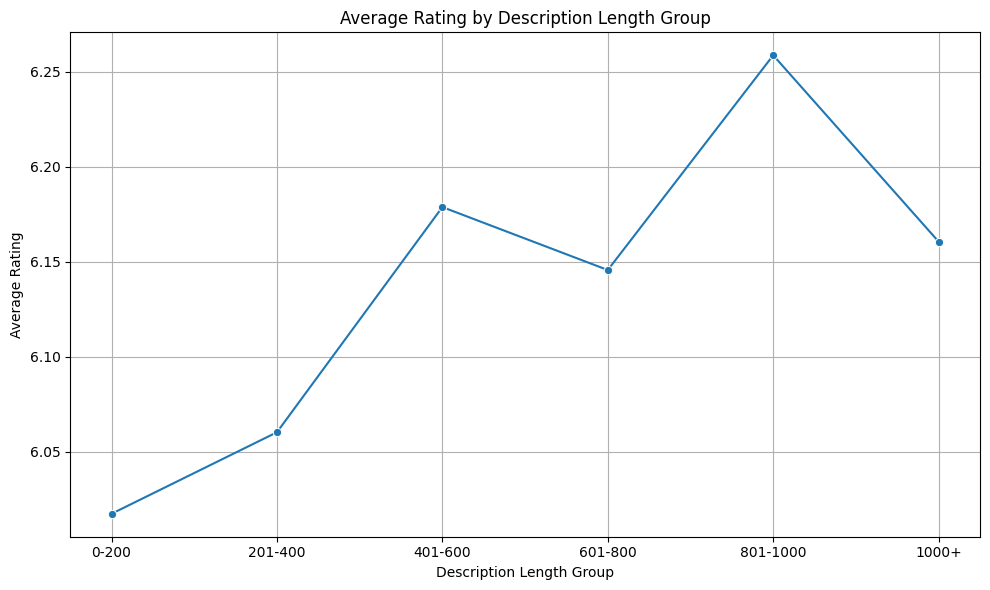

In [ ]:
#So sánh giữa độ dài mô tả và rating
df["desc_length_bin"] = pd.cut(df["description_length"], bins=[0, 200, 400, 600, 800, 1000, 2000],
                               labels=["0-200", "201-400", "401-600", "601-800", "801-1000", "1000+"])
grouped = df.groupby("desc_length_bin", observed=True)["rating"].mean().dropna()

plt.figure(figsize=(10, 6))
sns.lineplot(x=grouped.index.astype(str), y=grouped.values, marker="o")
plt.title("Average Rating by Description Length Group")
plt.xlabel("Description Length Group")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Đếm tổng từ, tổng từ khác nhau
all_words = [word for desc in df["cleaned_description"] if isinstance(desc, list) for word in desc]

total_words = len(all_words)
print(f"Total Words: {total_words:,}")

# Số từ khác nhau
diff_words = set(all_words)
print(f"Total Different Words: {len(diff_words):,}")

Total Words: 911,049
Total Different Words: 36,622


In [ ]:
word_counts = Counter(all_words)

#Số từ xuất hiện chỉ 1 lần
word_once = [word for word, count in word_counts.items() if count == 1]
print(f"Number of Words Appearing Only Once: {len(word_once):,}")

Number of Words Appearing Only Once: 13,974


In [ ]:
#Top 20 từ phổ biến
top_20 = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])
top_20["Percent"] = (top_20["Frequency"] / total_words * 100).round(2)
print("\nTop 20 Common Words:\n")
print(top_20)


Top 20 Common Words:

     Word  Frequency  Percent
0      to      38302     4.20
1      of      28978     3.18
2      in      20453     2.24
3     her      18944     2.08
4     his      18576     2.04
5      he      13656     1.50
6    with      10605     1.16
7    that      10223     1.12
8     she       9338     1.02
9     for       8682     0.95
10     by       7399     0.81
11    him       7160     0.79
12    who       6592     0.72
13     on       6181     0.68
14      a       5981     0.66
15     ha       5822     0.64
16   from       5371     0.59
17   when       5264     0.58
18     at       4619     0.51
19  their       4489     0.49


In [ ]:
#Bigram
df["cleaned_description"] = df["cleaned_description"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=5)
X = vectorizer.fit_transform(df["cleaned_description"])

bigrams = vectorizer.get_feature_names_out()
sum_bigrams = X.sum(axis=0).A1
bigram_freq = pd.Series(sum_bigrams, index=bigrams).sort_values(ascending=False)

bigram_df = bigram_freq.head(20).reset_index()
bigram_df.columns = ["Bigram", "Frequency"]

print("\nTop 20 Most Frequent Bigrams:\n")
print(bigram_df.to_string(index=False))



Top 20 Most Frequent Bigrams:

    Bigram  Frequency
    of his       2113
    of her       1501
   that he       1475
   in love       1437
     to be       1347
    to his       1167
    to her       1118
 love with       1117
  with her       1102
  that she       1094
  his wife       1073
   ha been       1024
    in his       1008
her father       1004
    her to       1001
    him to       1001
     go to        977
     he ha        863
   fall in        847
    one of        846


In [ ]:
#Trigram
vectorizer = CountVectorizer(ngram_range=(3, 3), min_df=5)
X = vectorizer.fit_transform(df["cleaned_description"])

trigrams = vectorizer.get_feature_names_out()
sum_trigrams = X.sum(axis=0).A1
trigram_freq = pd.Series(sum_trigrams, index=trigrams).sort_values(ascending=False)

trigram_df = trigram_freq.head(20).reset_index()
trigram_df.columns = ["Trigram", "Frequency"]

print("\nTop 20 Most Frequent Trigrams:\n")
print(trigram_df.to_string(index=False))



Top 20 Most Frequent Trigrams:

       Trigram  Frequency
  in love with       1102
  fall in love        809
   in order to        350
   to new york        205
    that he ha        203
 love with her        187
   in new york        186
   who ha been        173
  that he will        147
   that she ha        147
    in time to        141
  to marry him        140
  in search of        135
      to go to        128
  with help of        118
   take her to        113
      he go to        110
    he doe not        108
of her husband        102
   to save her        102


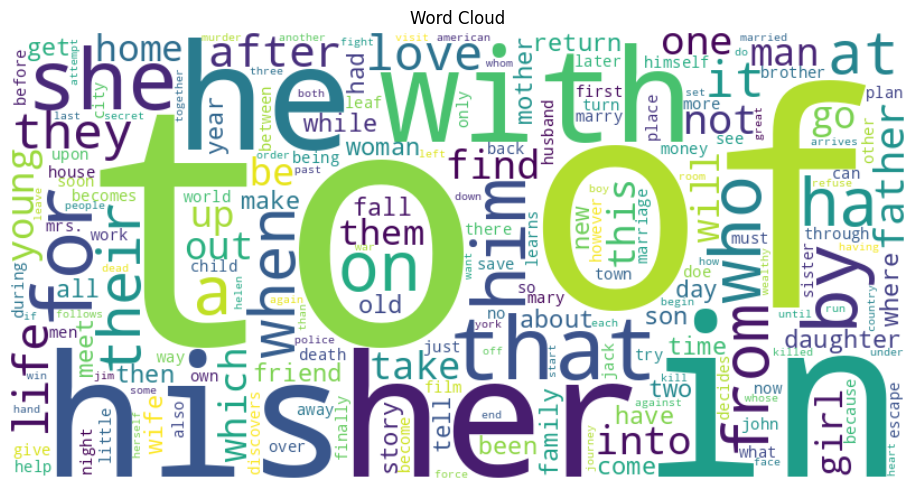

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.tight_layout()
plt.show()

In [ ]:
#  Đếm từ xuất hiện nhiều hơn 0.1% tổng số từ
threshold = 0.001 * total_words
common_words = [(word, count) for word, count in word_counts.items() if count >= threshold]
print(f"\nNumber of words appearing > 0.1% of total words ({int(threshold)} times): {len(common_words)}")

#  Đếm từ xuất hiện nhiều hơn 0.01% tổng số từ
threshold = 0.0001 * total_words
common_words = [(word, count) for word, count in word_counts.items() if count >= threshold]
print(f"\nNumber of words appearing > 0.01% of total words ({int(threshold)} times): {len(common_words)}")


Number of words appearing > 0.1% of total words (911 times): 105

Number of words appearing > 0.01% of total words (91 times): 1266
